In [7]:

!pip install nibabel numpy matplotlib scikit-image plotly ipywidgets -q

import nibabel as nib
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import os
from glob import glob

In [8]:
# Cell 2: Define Data Paths and Load Functions

# Your dataset paths - Update these paths to match your actual folder structure
OTHER_NEOPLASMS_PATH = r"C:\Users\M S I\Downloads\2NDYR_RESEARCH\BraTS-Africa\51_OtherNeoplasms"
GLIOMA_PATH = r"C:\Users\M S I\Downloads\2NDYR_RESEARCH\BraTS-Africa\95_Glioma"

def get_all_cases(base_path):
    """Get all patient case folders from a directory"""
    path = Path(base_path)
    if not path.exists():
        print(f"⚠️  Path does not exist: {base_path}")
        return []
    return [d for d in path.iterdir() if d.is_dir()]

def load_nifti(file_path):
    """Load a NIFTI file and return the image data"""
    img = nib.load(str(file_path))
    return img.get_fdata()

def find_modalities(case_folder):
    """Find all MRI modalities and segmentation in a case folder
    BraTS typically has: T1, T1ce, T2, FLAIR, and seg(segmentation)
    """
    files = {}
    for f in Path(case_folder).glob("*.nii.gz"):
        fname = f.name.lower()
        if "t1ce" in fname:
            files['t1ce'] = f
        elif "t1" in fname and "t1ce" not in fname:
            files['t1'] = f
        elif "t2" in fname and "flair" not in fname:
            files['t2'] = f
        elif "flair" in fname:
            files['flair'] = f
        elif "seg" in fname:
            files['seg'] = f
    return files

# List all available cases
print("=== Other Neoplasms Cases ===")
neoplasms_cases = get_all_cases(OTHER_NEOPLASMS_PATH)
print(f"Found {len(neoplasms_cases)} cases")

print("\n=== Glioma Cases ===")
glioma_cases = get_all_cases(GLIOMA_PATH)
print(f"Found {len(glioma_cases)} cases")

=== Other Neoplasms Cases ===
Found 51 cases

=== Glioma Cases ===
Found 95 cases



--- Glioma Sample ---
Loaded seg: shape = (240, 240, 155)
Loaded t1: shape = (240, 240, 155)
Loaded t2: shape = (240, 240, 155)


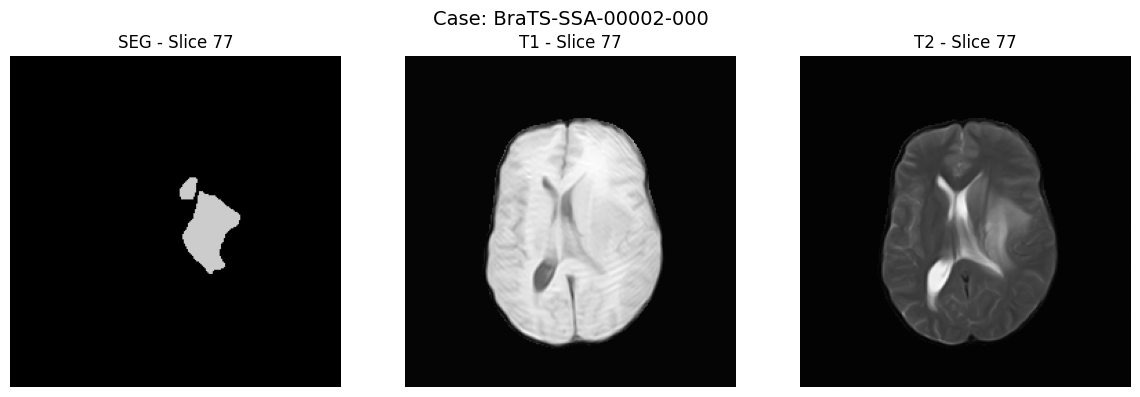


--- Other Neoplasms Sample ---
Loaded seg: shape = (240, 240, 155)
Loaded t1: shape = (240, 240, 155)
Loaded t2: shape = (240, 240, 155)


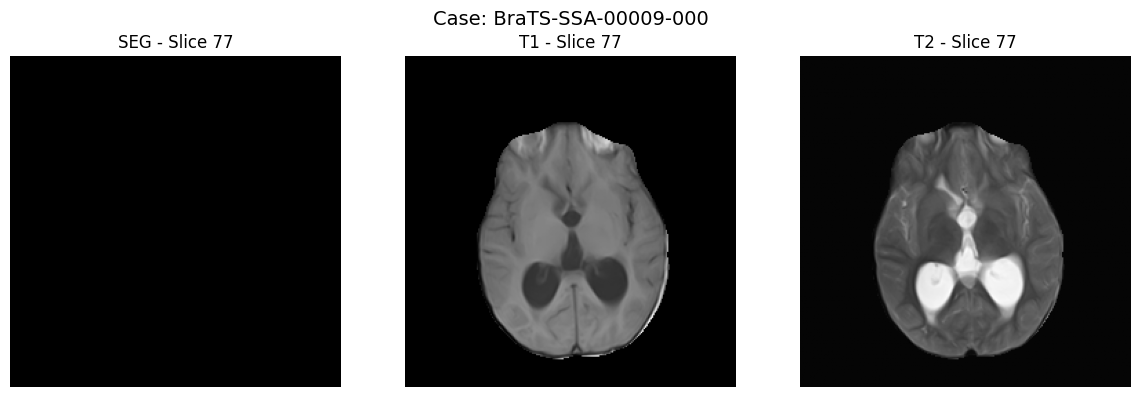

In [9]:
# Cell 3: 2D Slice Visualization for Diagnosis

def visualize_2d_slices(case_folder, slice_idx=None):
    """
    Visualize 2D slices from all modalities for diagnosis
    """
    modalities = find_modalities(case_folder)
    
    if not modalities:
        print(f"No NIFTI files found in {case_folder}")
        return
    
    # Load all available modalities
    data = {}
    for name, path in modalities.items():
        data[name] = load_nifti(path)
        print(f"Loaded {name}: shape = {data[name].shape}")
    
    # Get middle slice if not specified
    if slice_idx is None:
        sample = list(data.values())[0]
        slice_idx = sample.shape[2] // 2
    
    # Create visualization
    n_modalities = len(data)
    fig, axes = plt.subplots(1, n_modalities, figsize=(4*n_modalities, 4))
    
    if n_modalities == 1:
        axes = [axes]
    
    for ax, (name, img) in zip(axes, data.items()):
        if name == 'seg':
            # Show segmentation with colormap
            ax.imshow(img[:, :, slice_idx].T, cmap='nipy_spectral', origin='lower')
        else:
            ax.imshow(img[:, :, slice_idx].T, cmap='gray', origin='lower')
        ax.set_title(f"{name.upper()} - Slice {slice_idx}")
        ax.axis('off')
    
    plt.suptitle(f"Case: {Path(case_folder).name}", fontsize=14)
    plt.tight_layout()
    plt.show()
    
    return data

# Example: Visualize first case from each category
if glioma_cases:
    print("\n--- Glioma Sample ---")
    glioma_data = visualize_2d_slices(glioma_cases[0])

if neoplasms_cases:
    print("\n--- Other Neoplasms Sample ---")
    neoplasms_data = visualize_2d_slices(neoplasms_cases[0])

In [10]:
# Cell 4: Interactive 2D Slice Browser

from ipywidgets import interact, IntSlider

def interactive_slice_viewer(case_folder):
    """Interactive slider to browse through all slices"""
    modalities = find_modalities(case_folder)
    
    # Load data
    data = {name: load_nifti(path) for name, path in modalities.items()}
    n_slices = list(data.values())[0].shape[2]
    
    def show_slice(slice_num):
        n_mod = len(data)
        fig, axes = plt.subplots(1, n_mod, figsize=(4*n_mod, 4))
        if n_mod == 1:
            axes = [axes]
            
        for ax, (name, img) in zip(axes, data.items()):
            if name == 'seg':
                ax.imshow(img[:, :, slice_num].T, cmap='nipy_spectral', origin='lower')
            else:
                ax.imshow(img[:, :, slice_num].T, cmap='gray', origin='lower')
            ax.set_title(name.upper())
            ax.axis('off')
        plt.tight_layout()
        plt.show()
    
    interact(show_slice, slice_num=IntSlider(min=0, max=n_slices-1, step=1, value=n_slices//2))

# Uncomment to use interactive viewer
# interactive_slice_viewer(glioma_cases[0])

In [11]:
# Cell 5: 3D Tumor Visualization

import plotly.graph_objects as go
from skimage import measure

def visualize_3d_tumor(case_folder, threshold=0.5):
    """
    Convert segmentation to 3D surface visualization
    Tumor labels in BraTS:
    - 1: Necrotic/Non-enhancing tumor core
    - 2: Peritumoral edema
    - 3 or 4: Enhancing tumor
    """
    modalities = find_modalities(case_folder)
    
    if 'seg' not in modalities:
        print("No segmentation file found!")
        return
    
    seg_data = load_nifti(modalities['seg'])
    print(f"Segmentation shape: {seg_data.shape}")
    print(f"Unique labels: {np.unique(seg_data)}")
    
    # Create 3D visualization for each tumor region
    colors = {
        1: 'red',      # Necrotic core
        2: 'green',    # Edema
        4: 'blue'      # Enhancing tumor (label can be 3 or 4)
    }
    
    labels_names = {
        1: 'Necrotic Core',
        2: 'Peritumoral Edema', 
        4: 'Enhancing Tumor'
    }
    
    fig = go.Figure()
    
    for label, color in colors.items():
        if label in seg_data:
            # Create binary mask for this label
            mask = (seg_data == label).astype(np.float32)
            
            if mask.sum() == 0:
                continue
            
            try:
                # Generate 3D surface mesh
                verts, faces, _, _ = measure.marching_cubes(mask, level=threshold)
                
                # Add surface to figure
                fig.add_trace(go.Mesh3d(
                    x=verts[:, 0],
                    y=verts[:, 1],
                    z=verts[:, 2],
                    i=faces[:, 0],
                    j=faces[:, 1],
                    k=faces[:, 2],
                    color=color,
                    opacity=0.5,
                    name=labels_names.get(label, f'Label {label}')
                ))
            except:
                print(f"Could not generate mesh for label {label}")
    
    fig.update_layout(
        title=f"3D Tumor Visualization: {Path(case_folder).name}",
        scene=dict(
            xaxis_title='X',
            yaxis_title='Y',
            zaxis_title='Z',
            aspectmode='data'
        ),
        width=800,
        height=600
    )
    
    fig.show()
    return seg_data

# Visualize 3D tumor from first glioma case
if glioma_cases:
    print("Generating 3D tumor visualization...")
    seg = visualize_3d_tumor(glioma_cases[0])

Generating 3D tumor visualization...
Segmentation shape: (240, 240, 155)
Unique labels: [0. 1. 2. 3.]
